In [1]:
import torch
from transformers import AutoModel, AutoTokenizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import pandas as pd
from genplasmid.dataset import genbank_to_glm2, read_genbank
import warnings
from datasets import load_dataset

from Bio import BiopythonParserWarning

# Suppress the specific warning
warnings.filterwarnings("ignore", category=BiopythonParserWarning, message="Attempting to parse malformed locus line:")

/srv/home/wconnell/anaconda3/envs/test/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = load_dataset("wconnell/openplasmid")
data = data.filter(lambda x: x['GenBank Raw'] != '')
data = data.map(lambda x: {'glm2_sequence': genbank_to_glm2(x['GenBank Raw'])})
all_feat = data['train'].to_pandas()

Map:   0%|          | 0/144691 [00:00<?, ? examples/s]/srv/home/wconnell/anaconda3/envs/test/lib/python3.9/site-packages/Bio/Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
Map: 100%|██████████| 144691/144691 [03:47<00:00, 635.82 examples/s]


In [4]:
backbone = read_genbank(all_feat[all_feat['ID'] == '127546']['GenBank Raw'].values[0])
for f in backbone.features:
    print(f.qualifiers)


{'mol_type': ['other DNA'], 'organism': ['synthetic DNA construct']}
{'label': ["pGEX 3'"], 'note': ['pGEX vectors, reverse primer']}
{'label': ['SP6 promoter'], 'note': ['promoter for bacteriophage SP6 RNA polymerase']}
{'label': ['SP6'], 'note': ['SP6 promoter, forward primer']}
{'gene': ['S. cerevisiae URA3'], 'label': ['URA3 promoter']}
{'codon_start': ['1'], 'gene': ['S. cerevisiae URA3'], 'product': ["orotidine-5'-phosphate decarboxylase, required for uracil biosynthesis"], 'label': ['URA3'], 'note': ['yeast auxotrophic marker, counterselectable with 5-fluoroorotic acid (5-FOA)'], 'translation': ['MSKATYKERAATHPSPVAAKLFNIMHEKQTNLCASLDVRTTKELLELVEALGPKICLLKTHVDILTDFSMEGTVKPLKALSAKYNFLLFEDRKFADIGNTVKLQYSAGVYRIAEWADITNAHGVVGPGIVSGLKQAAEEVTKEPRGLLMLAELSCKGSLSTGEYTKGTVDIAKSDKDFVIGFIAQRDMGGRDEGYDWLIMTPGVGLDDKGDALGQQYRTVDDVVSTGSDIIIVGRGLFAKGRDAKVEGERYRKAGWEAYLRRCGQQN']}
{'label': ['F1ori-F'], 'note': ['F1 origin, forward primer']}
{'codon_start': ['1'], 'product': ['yeast-enhanced green

In [5]:
n = 3
backbone.features[n].qualifiers
start, end = backbone.features[n].location.start, backbone.features[n].location.end
yegfp = str(backbone.seq[start:end])
len(yegfp)


{'label': ['SP6'], 'note': ['SP6 promoter, forward primer']}

18

In [18]:
yegfp

'ATGTCTAAAGGTGAAGAATTATTCACTGGTGTTGTCCCAATTTTGGTTGAATTAGATGGTGATGTTAATGGTCACAAATTTTCTGTCTCCGGTGAAGGTGAAGGTGATGCTACTTACGGTAAATTGACCTTAAAATTGATTTGTACTACTGGTAAATTGCCAGTTCCATGGCCAACCTTAGTCACTACTTTAGGTTATGGTTTGCAATGTTTTGCTAGATACCCAGATCATATGAAACAACATGACTTTTTCAAGTCTGCCATGCCAGAAGGTTATGTTCAAGAAAGAACTATTTTTTTCAAAGATGACGGTAACTACAAGACCAGAGCTGAAGTCAAGTTTGAAGGTGATACCTTAGTTAATAGAATCGAATTAAAAGGTATTGATTTTAAAGAAGATGGTAACATTTTAGGTCACAAATTGGAATACAACTATAACTCTCACAATGTTTACATCACTGCTGACAAACAAAAGAATGGTATCAAAGCTAACTTCAAAATTAGACACAACATTGAAGATGGTGGTGTTCAATTAGCTGACCATTATCAACAAAATACTCCAATTGGTGATGGTCCAGTCTTGTTACCAGACAACCATTACTTATCCTATCAATCTGCCTTATCCAAAGATCCAAACGAAAAGAGAGACCACATGGTCTTGTTAGAATTTGTTACTGCTGCTGGTATTACCCATGGTATGGATGAATTGTACAAATAA'

In [3]:
# Load the model and tokenizer (if not already loaded)
device = 2
model = AutoModel.from_pretrained('tattabio/gLM2_150M', torch_dtype=torch.bfloat16, trust_remote_code=True).cuda(device)
tokenizer = AutoTokenizer.from_pretrained('tattabio/gLM2_150M', trust_remote_code=True)

In [5]:
from torch.utils.data import DataLoader
import torch
import numpy as np
from tqdm import tqdm

# Create dataloaders
# Define a function to tokenize the sequences
def tokenize_function(examples):
    return tokenizer(examples['glm2_sequence'], truncation=True, padding='max_length', max_length=4096)

# Apply tokenization to the datasets
data = data.map(tokenize_function, batched=True)

# Set the format of the datasets to return PyTorch tensors
data.set_format(type='torch', columns=['input_ids', 'attention_mask'])

In [5]:
# Function to generate embeddings
def generate_embeddings(dataloader):
    embeddings = []
    model.eval()
    device = model.device  # Get the device of the model
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generating embeddings"):
            batch_embeddings = model(input_ids=batch['input_ids'].to(device), output_hidden_states=True).last_hidden_state
            embeddings.extend(batch_embeddings.mean(dim=1).float().cpu().numpy())
    return np.array(embeddings)

# Create dataloaders
dataloader = DataLoader(data['train'], batch_size=80, shuffle=False)

# Generate embeddings for train and eval datasets
embeddings = generate_embeddings(dataloader)

print(f"Train embeddings shape: {embeddings.shape}")
np.save('data/glm2v2_embeddings.npy', embeddings)

Generating embeddings:   0%|          | 0/1809 [00:00<?, ?it/s]

Generating embeddings: 100%|██████████| 1809/1809 [2:14:20<00:00,  4.46s/it]  


Train embeddings shape: (144691, 640)


## Embeddings analysis

In [6]:
# def get_addgene_genes(x):
#     result = []
#     for key in x.keys():
#         if 'Gene/Insert' in key:
#             # Check if x[key] is a dictionary before accessing 'Entrez Gene'
#             if isinstance(x[key], dict) and 'Entrez Gene' in x[key]:
#                 out = x[key]['Entrez Gene']
#                 if out != '':
#                     result.append(out)
#     if result:
#         return pd.DataFrame.from_records({'ID': [x['ID']] * len(result), 'Gene/Insert': result})

# train_insert = pd.concat([get_addgene_genes(x) for x in data['train']])


In [62]:
import re

def clean_gene_name(gene):
    # Remove common prefixes and suffixes
    gene = re.sub(r'^(human|mouse|rat|h|m|r)\s*', '', gene, flags=re.IGNORECASE)
    gene = re.sub(r'\s*(gene|protein)$', '', gene, flags=re.IGNORECASE)
    
    # Remove parentheses and their contents
    gene = re.sub(r'\s*\([^)]*\)', '', gene)
    
    # Remove specific strings
    gene = re.sub(r'(or nptII)', '', gene)
    
    # Standardize common gene names
    gene_map = {
        'neo': 'neomycin resistance',
        'amp': 'ampicillin resistance',
        'gfp': 'GFP',
        'egfp': 'GFP',
        'rfp': 'RFP',
        'dsred': 'RFP',
        'kan': 'kanamycin resistance',
    }
    
    for key, value in gene_map.items():
        if re.search(rf'\b{key}\b', gene, re.IGNORECASE):
            return value
    
    return gene.strip().lower()

def extract_cds_genes(record):
    genes = []
    for feature in record.features:
        if feature.type == 'CDS':
            gene = feature.qualifiers.get('gene', [])
            product = feature.qualifiers.get('product', [])
            if gene:
                genes.append(clean_gene_name(gene[0]))
            elif product:
                genes.append(clean_gene_name(product[0]))
    return genes

def calculate_gc_content(sequence):
    gc_count = sequence.count('G') + sequence.count('C')
    total_count = len(sequence)
    return gc_count / total_count if total_count > 0 else 0

In [63]:
# extract sequence features
all_feat['GenBank'] = all_feat['GenBank Raw'].map(read_genbank)
all_feat['CDS genes'] = all_feat['GenBank'].map(extract_cds_genes)
all_feat['Sequence length'] = all_feat['GenBank'].map(lambda x: len(x.seq))
all_feat['GC content'] = all_feat['GenBank'].map(calculate_gc_content)

In [64]:
from collections import Counter
import itertools

# Count gene occurrences
gene_counts = Counter(list(itertools.chain.from_iterable(all_feat['CDS genes'].values)))

# Get the top 20 most common genes
top_20_genes = dict(gene_counts.most_common(20))
top_20_genes

{'bla': 87025,
 'GFP': 29536,
 'factor xa recognition and cleavage site': 24160,
 '6xhis affinity tag': 23993,
 'aph-ii': 20187,
 'antigenic peptide corresponding to amino acids 655 to 669 of the hiv envelope protein gp41': 19299,
 'nuclear localization signal of sv40 large t antigen': 18889,
 'pac from streptomyces alboniger': 16844,
 'aph-ia': 15933,
 'aminoglycoside phosphotransferase': 14731,
 'a epitope tag': 11084,
 'laci': 9892,
 'flag epitope tag, followed by an enterokinase cleavage site': 9523,
 'op': 8504,
 'RFP': 8281,
 'tobacco etch virus protease recognition and cleavage site': 8225,
 'cas9 endonuclease from the streptococcus pyogenes type ii crispr/cas system': 7906,
 'epitope tag from simian virus 5': 7229,
 'yc epitope tag': 6547,
 'cat': 6208}

In [65]:
def map_genes(genes):
    keywords = ['gfp', 'cas9', '6xhis', 'RFP', 'factor xa', 'aph-ii', 'aph-ia', 'laci', ' op ', 't antigen']
    for gene in genes:
        for keyword in keywords:
            if re.search(keyword, gene, re.IGNORECASE):
                return keyword
    return None

all_feat['query_gene'] = all_feat['CDS genes'].map(map_genes)

# Display the first few rows to verify
print(all_feat[['CDS genes', 'query_gene']].head(10))

# Count of rows for each mapped gene and None
gene_counts = all_feat['query_gene'].value_counts(dropna=False)
print("\nCounts for each mapped gene:")
print(gene_counts)

# Percentage of rows with a mapped gene
mapped_percentage = (all_feat['query_gene'].notna().sum() / len(all_feat)) * 100
print(f"\nPercentage of rows with a mapped gene: {mapped_percentage:.2f}%")

                                                CDS genes query_gene
ID                                                                  
40378   [baculovirus late expression factor 2, baculov...      6xhis
31426                      [a epitope tag, a epitope tag]       None
10966                   [epitope tag from simian virus 5]       None
45491                                [6xhis affinity tag]      6xhis
138521  [ii, v, vii, ix, viii, RFP, aminoglycoside pho...        RFP
171004  [antigenic peptide corresponding to amino acid...  factor xa
201764  [bla, ionally designed epitope tag that forms ...     aph-ia
171349                                             [aada]       None
172489  [aminoglycoside phosphotransferase, aph-ia, op...     aph-ia
21969                                                  []       None

Counts for each mapped gene:
query_gene
None         54489
factor xa    15635
6xhis        15410
gfp          13899
aph-ii       12514
aph-ia       10046
t antigen     940

In [11]:
import scanpy as sc

if 'embeddings' not in locals():
    embeddings = np.load('data/glm2v2_embeddings.npy')

adata = sc.AnnData(embeddings, obs=all_feat)
adata.obs['log(seq_len)'] = np.log10(adata.obs['Sequence length'])
sc.tl.pca(adata)
adata

/srv/home/wconnell/anaconda3/envs/test/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 144691 × 640
    obs: 'Name', 'ID', 'Flame', 'Purpose', 'Depositing Lab', 'Publication', 'GenBank File', 'Sequence Type', 'GenBank Raw', 'Backbone', 'Growth in Bacteria', 'Terms and Licenses', 'References', 'Gene/Insert 1', 'Cloning Information for Gene/Insert 1', 'Gene/Insert 2', 'Cloning Information for Gene/Insert 2', 'Gene/Insert 3', 'Cloning Information for Gene/Insert 3', 'glm2_sequence', 'GenBank', 'CDS genes', 'Sequence length', 'GC content', 'query_gene', 'log(seq_len)'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

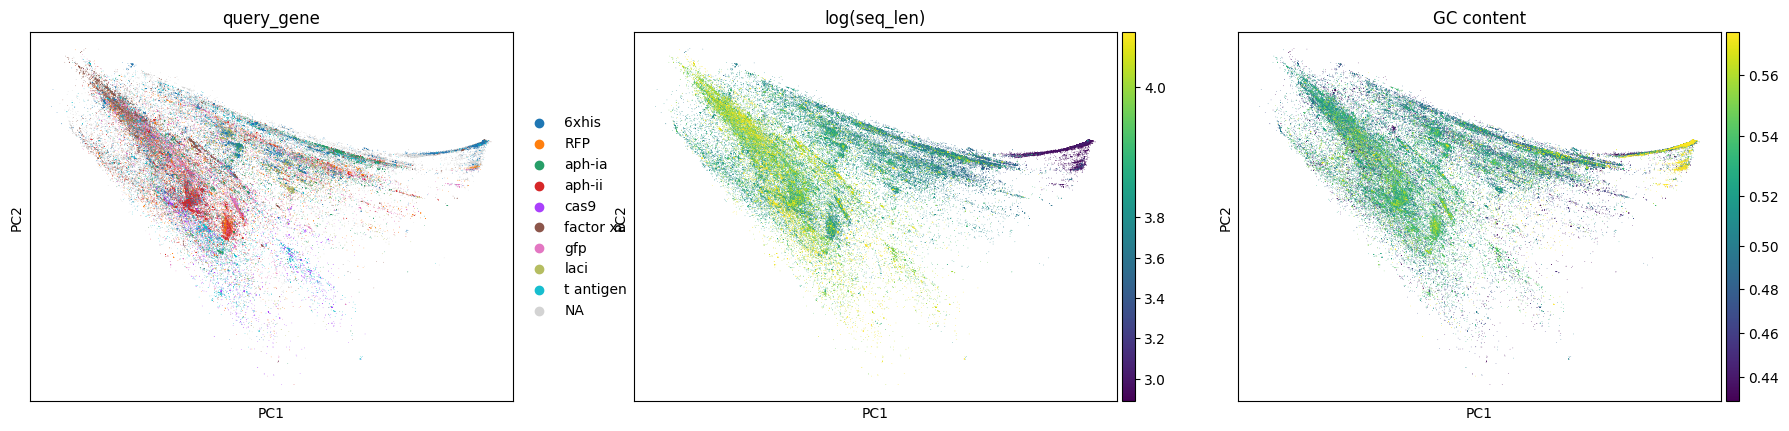

In [12]:
sc.pl.pca(
    adata, 
    color=['query_gene', 'log(seq_len)', 'GC content'],
    palette=sc.pl.palettes.vega_20_scanpy,
    ncols=3,
    vmin='p5',
    vmax='p95',
    vcenter='p50'
)

(-100.0, 30000.0)

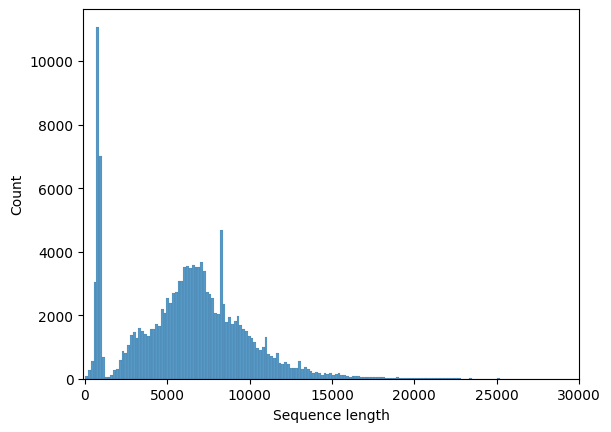

<Axes: xlabel='log(seq_len)', ylabel='Count'>

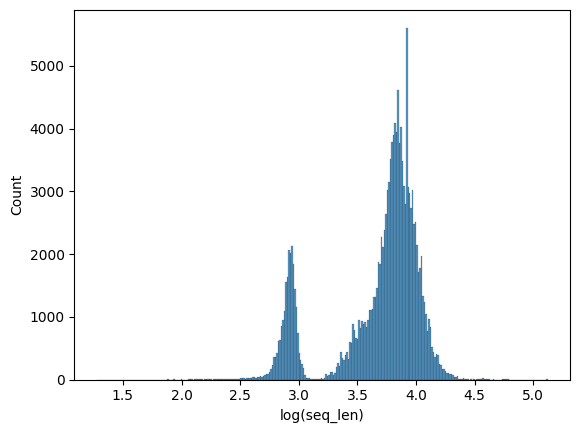

In [13]:
ax = sns.histplot(adata.obs['Sequence length'])
ax.set_xlim((-100, 3e4))
plt.show()
sns.histplot(adata.obs['log(seq_len)'])
plt.show()

(0.0, 30000.0)

Text(0.5, 0, 'PCA1')

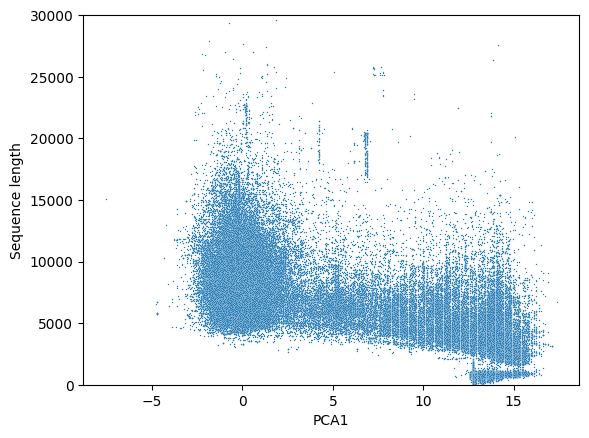

In [14]:
ax = sns.scatterplot(x=adata.X[:, 0], y=adata.obs['Sequence length'], s=1)
ax.set_ylim(0, 30000)
ax.set_xlabel('PCA1')
plt.show()

## Finetune

In [4]:
# # setup datasets
# data = load_dataset("wconnell/openplasmid")
# data = data.filter(lambda x: x['GenBank Raw'] != '')
ft_data = data['train'].train_test_split(test_size=0.2)
# ft_data = ft_data.map(lambda x: {'glm2_sequence': genbank_to_glm2(x['GenBank Raw'])})
ft_data = ft_data.filter(lambda x: x['glm2_sequence'] != '')


def tokenize_function(examples):
    return tokenizer(examples['glm2_sequence'], truncation=True, padding='max_length', max_length=4096)

# Apply tokenization to the datasets
ft_data = ft_data.map(tokenize_function, batched=True)

# Set the format of the datasets to return PyTorch tensors
ft_data.set_format(type='torch', columns=['input_ids', 'attention_mask'])

Filter:   0%|          | 0/115752 [00:00<?, ? examples/s]

Map: 100%|██████████| 27770/27770 [01:20<00:00, 344.31 examples/s]


In [5]:
from transformers import AutoModelForMaskedLM, AutoTokenizer, DataCollatorForLanguageModeling
from transformers import TrainingArguments, Trainer
import torch
import numpy as np


# Load the pre-trained model and tokenizer
model = AutoModelForMaskedLM.from_pretrained('tattabio/gLM2_150M', torch_dtype=torch.bfloat16, trust_remote_code=True).cuda()
tokenizer = AutoTokenizer.from_pretrained('tattabio/gLM2_150M', trust_remote_code=True)


# Create a data collator for masked language modeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm_probability=0.15
)

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./data/models/finetune-v2",
    num_train_epochs=5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=5, # effective batch size of (per_device_bs * n_device * accum_steps)
    save_steps=50_000,
    save_total_limit=5,
    logging_dir='./data/models/finetune-v2/logs',
    logging_steps=1,  # Log every step
    eval_strategy="epoch",  # Evaluate at the end of each epoch
)

# Define the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ft_data['train'],
    eval_dataset=ft_data['test'],
    data_collator=data_collator,
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained("./data/models/finetune-v2/final-model")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/srv/home/wconnell/anaconda3/envs/test/lib/python3.9/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/srv/home/wconnell/anaconda3/envs/test/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but

Epoch,Training Loss,Validation Loss
0,0.342700,0.342292
1,0.343800,0.328001
2,0.274900,0.325755
3,0.237900,0.325017
4,0.302700,0.325282


/srv/home/wconnell/anaconda3/envs/test/lib/python3.9/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/srv/home/wconnell/anaconda3/envs/test/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=27750, training_loss=0.3743709254909206, metrics={'train_runtime': 85103.1852, 'train_samples_per_second': 6.522, 'train_steps_per_second': 0.326, 'total_flos': 2.0791199202174566e+18, 'train_loss': 0.3743709254909206, 'epoch': 4.999279383151978})

<Figure size 700x450 with 0 Axes>

Text(0.5, 1.0, 'Training and Evaluation Loss over Steps')

Text(0.5, 0, 'Step')

Text(0, 0.5, 'Loss')

Text(5, 5, 'Train Start: 1.4668')

Text(-5, 5, 'Train End: 0.3027')

Text(5, -5, 'Eval Start: 0.3423')

Text(-5, -5, 'Eval End: 0.3253')

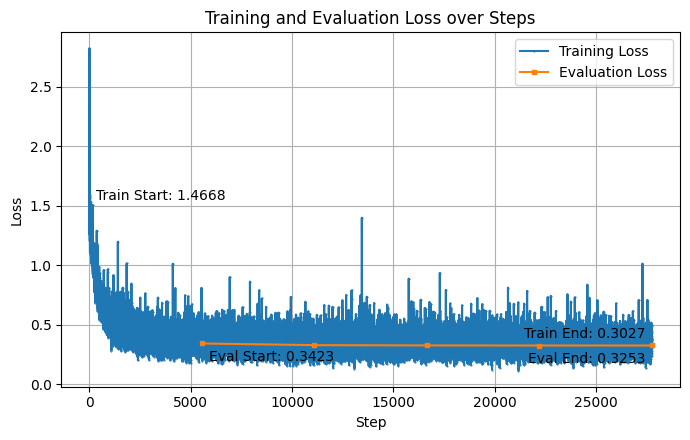

Final training loss: 0.3027
Final evaluation loss: 0.3253


In [6]:
# Plot the training and evaluation loss
import matplotlib.pyplot as plt
import json

# Extract the loss values from the training output
if 'trainer' not in locals() or not hasattr(trainer.state, 'log_history'):
    log_history = json.load(open('data/models/finetune-v2/checkpoint-27750/trainer_state.json'))
    loss_values = log_history['log_history']
else:
    loss_values = trainer.state.log_history

# Extract 'loss' and 'eval_loss' from each dictionary in the list
train_losses = [log['loss'] for log in loss_values if 'loss' in log]
eval_losses = [log['eval_loss'] for log in loss_values if 'eval_loss' in log]
train_steps = list(range(1, len(train_losses) + 1))
eval_steps = [step * (len(train_losses) // len(eval_losses)) for step in range(1, len(eval_losses) + 1)]

# Create the plot
plt.figure(figsize=(7, 4.5))
plt.plot(train_steps, train_losses, marker='o', markersize=0.5, label='Training Loss')
plt.plot(eval_steps, eval_losses, marker='s', markersize=3, label='Evaluation Loss')
plt.title('Training and Evaluation Loss over Steps')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Add text annotations for start and end loss values
plt.annotate(f'Train Start: {train_losses[0]:.4f}', xy=(1, train_losses[0]), xytext=(5, 5), 
             textcoords='offset points', ha='left', va='bottom')
plt.annotate(f'Train End: {train_losses[-1]:.4f}', xy=(len(train_losses), train_losses[-1]), xytext=(-5, 5), 
             textcoords='offset points', ha='right', va='bottom')
plt.annotate(f'Eval Start: {eval_losses[0]:.4f}', xy=(eval_steps[0], eval_losses[0]), xytext=(5, -5), 
             textcoords='offset points', ha='left', va='top')
plt.annotate(f'Eval End: {eval_losses[-1]:.4f}', xy=(eval_steps[-1], eval_losses[-1]), xytext=(-5, -5), 
             textcoords='offset points', ha='right', va='top')

plt.tight_layout()
plt.show()

# Print the final losses
print(f"Final training loss: {train_losses[-1]:.4f}")
print(f"Final evaluation loss: {eval_losses[-1]:.4f}")


## Finetuned embeddings

In [3]:
from transformers import AutoModel
import torch
from safetensors import safe_open

# Create the model from the config
model = AutoModel.from_pretrained('tattabio/gLM2_150M', trust_remote_code=True)

# Load the safetensors file
checkpoint_path = 'data/models/finetune-v2/checkpoint-27750/model.safetensors'
with safe_open(checkpoint_path, framework="pt", device="cpu") as f:
    state_dict = {k: f.get_tensor(k) for k in f.keys()}

# Remove the 'glm2.' prefix from the keys if present
state_dict = {k.replace('glm2.', ''): v for k, v in state_dict.items()}

# Load the state dict into the model
incompatible_keys = model.load_state_dict(state_dict, strict=False)

print("Unexpected keys:", incompatible_keys.unexpected_keys)
print("Missing keys:", incompatible_keys.missing_keys)

# Move the model to GPU and convert to bfloat16
# model = model.cuda().to(torch.bfloat16)
model = model.to(torch.bfloat16)

print("Model loaded successfully!")

Unexpected keys: ['lm_head.norm.weight', 'lm_head.proj_output.weight']
Missing keys: []
Model loaded successfully!


In [23]:
from torch.utils.data import DataLoader
import torch
import numpy as np
from tqdm import tqdm

tokenizer = AutoTokenizer.from_pretrained('tattabio/gLM2_150M', trust_remote_code=True)

# Function to generate embeddings
def generate_embeddings(dataloader):
    embeddings = []
    model.eval()
    device = model.device  # Get the device of the model
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generating embeddings"):
            batch_embeddings = model(input_ids=batch['input_ids'].to(device), output_hidden_states=True).last_hidden_state
            embeddings.extend(batch_embeddings.mean(dim=1).float().cpu().numpy())
    return np.array(embeddings)

# Create dataloaders
# Define a function to tokenize the sequences
def tokenize_function(examples):
    return tokenizer(examples['glm2_sequence'], truncation=True, padding='max_length', max_length=4096)

# DO NOT run this as original embeddings computed on all the data
# filter out empty sequences
# data = data.filter(lambda x: x['glm2_sequence'] != '')

# Apply tokenization to the datasets
data = data.map(tokenize_function, batched=True)

def convert_id(example):
    id_value = example['ID']
    if isinstance(id_value, list):
        id_value = id_value[0] if id_value else None
    try:
        return {'ID': float(id_value) if id_value is not None else None}
    except (ValueError, TypeError):
        return {'ID': None}

data = data.map(convert_id)

# Set the format of the datasets to return PyTorch tensors
data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'ID'])

Map: 100%|██████████| 144691/144691 [04:22<00:00, 551.24 examples/s]


In [48]:
from accelerate import Accelerator
from accelerate import notebook_launcher

# Function to generate embeddings
def generate_embeddings_accel(model, data):
    dataloader = DataLoader(data, batch_size=8, shuffle=False)
    accelerator = Accelerator()
    model, dataloader = accelerator.prepare(model, dataloader)
    model.eval()
    
    embeddings = []
    ids = []
    
    total_samples = len(data)  # Store the original number of samples
    
    # Use tqdm for progress bar
    for batch in tqdm(dataloader, desc="Generating embeddings"):
        with torch.no_grad():
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], output_hidden_states=True)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).float()
            embeddings.extend(accelerator.gather(batch_embeddings).cpu().numpy())
            ids.extend(accelerator.gather(batch['ID']).cpu().numpy())
    
    # Only the main process should save the data
    if accelerator.is_main_process:
        # Remove any padding added by the Accelerator
        embeddings = embeddings[:total_samples]
        ids = ids[:total_samples]
        
        df = pd.DataFrame(embeddings)
        df.index = ids
        df.index.name = 'ID'
        df.index = df.index.astype(int)
        df.to_parquet('data/glm2v2_ft_embeddings.parquet')

        print(f"Generated embeddings for {len(df)} samples")

# Generate embeddings
notebook_launcher(generate_embeddings_accel, [model, data['train']], num_processes=4)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Launching training on 4 GPUs.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Generated embeddings for 144691 samples


In [56]:
# load the embeddings
ft_embeddings = pd.read_parquet('data/glm2v2_ft_embeddings.parquet')
ft_embeddings.shape
ft_embeddings = ft_embeddings.dropna()
ft_embeddings.shape

(144691, 640)

In [59]:
all_feat = all_feat.set_index('ID')
all_feat.index = all_feat.index.astype(int)
all_feat = all_feat.loc[ft_embeddings.index]

In [72]:
import scanpy as sc

ft_adata = sc.AnnData(ft_embeddings.values, obs=all_feat)
ft_adata.obs['log(seq_len)'] = np.log10(ft_adata.obs['Sequence length'])
sc.tl.pca(ft_adata)
ft_adata

/srv/home/wconnell/anaconda3/envs/test/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 138784 × 640
    obs: 'Name', 'Flame', 'Purpose', 'Depositing Lab', 'Publication', 'GenBank File', 'Sequence Type', 'GenBank Raw', 'Backbone', 'Growth in Bacteria', 'Terms and Licenses', 'References', 'Gene/Insert 1', 'Cloning Information for Gene/Insert 1', 'Gene/Insert 2', 'Cloning Information for Gene/Insert 2', 'Gene/Insert 3', 'Cloning Information for Gene/Insert 3', 'glm2_sequence', 'GenBank', 'CDS genes', 'Sequence length', 'GC content', 'query_gene', 'log(seq_len)'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

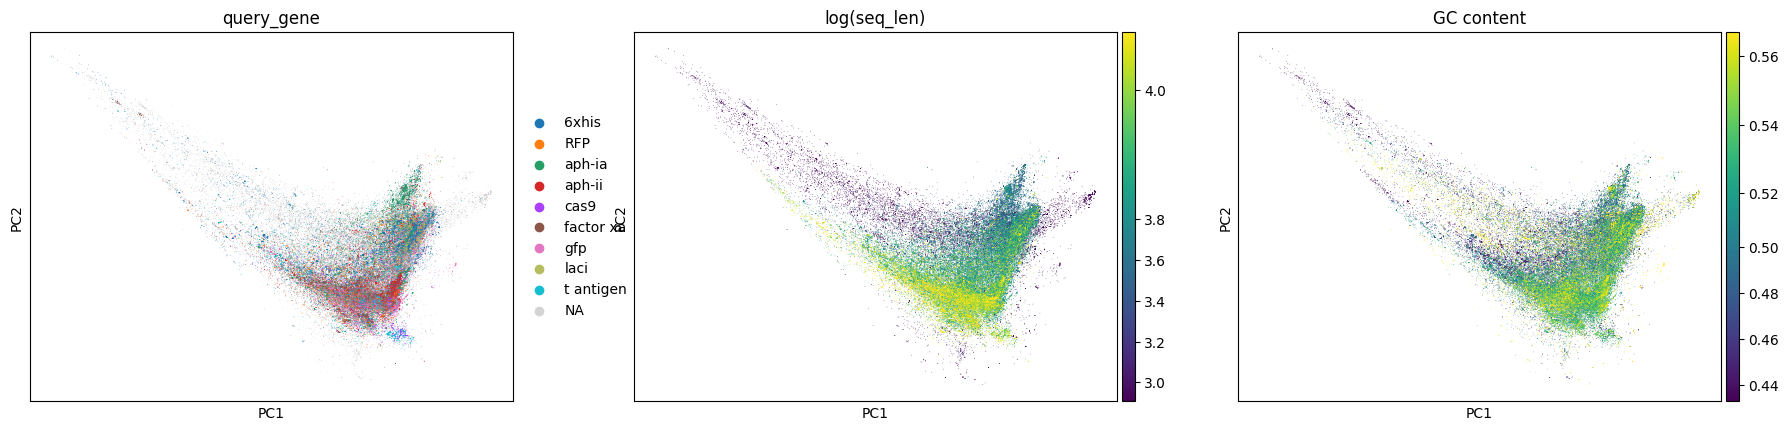

In [73]:
sc.pl.pca(
    ft_adata, 
    color=['query_gene', 'log(seq_len)', 'GC content'],
    palette=sc.pl.palettes.vega_20_scanpy,
    ncols=3,
    vmin='p5',
    vmax='p95',
    vcenter='p50'
)

## Generate sequences

In [28]:
import torch
from safetensors import safe_open
from transformers import AutoModelForMaskedLM, AutoTokenizer

load_finetuned = False

tokenizer = AutoTokenizer.from_pretrained('tattabio/gLM2_150M', trust_remote_code=True)

# Load finetuned model
if load_finetuned:
    print("Loading finetuned model")
    model = AutoModelForMaskedLM.from_pretrained('tattabio/gLM2_150M', torch_dtype=torch.bfloat16, trust_remote_code=True).cuda()
    # Load the safetensors file
    checkpoint_path = 'data/models/finetune/checkpoint-6940/model.safetensors'
    with safe_open(checkpoint_path, framework="pt", device="cpu") as f:
        state_dict = {k: f.get_tensor(k) for k in f.keys()}

    # Load the state dict into the model
    incompatible_keys = model.load_state_dict(state_dict, strict=False)
    print(incompatible_keys)
else:
    print("Loading pretrained model")
    model = AutoModelForMaskedLM.from_pretrained('tattabio/gLM2_150M', trust_remote_code=True).cuda()

Loading pretrained model


In [26]:
from torch.utils.data import DataLoader
import torch
import numpy as np
from tqdm import tqdm
from datasets import load_dataset
from genplasmid.datasets import genbank_to_glm2, read_genbank

tokenizer = AutoTokenizer.from_pretrained('tattabio/gLM2_150M', trust_remote_code=True)

# Create dataloaders
# Define a function to tokenize the sequences
def tokenize_function(examples):
    return tokenizer(examples['glm2_sequence'], truncation=True, padding='max_length', max_length=4096)

# data = load_dataset("wconnell/openplasmid")
# data = data.filter(lambda x: x['GenBank Raw'] != '')
# data = data.map(lambda x: {'glm2_sequence': genbank_to_glm2(x['GenBank Raw'])})
# # all_feat = data['train'].to_pandas()

# # Apply tokenization to the datasets
# data = data.map(tokenize_function, batched=True)

# # Set the format of the datasets to return PyTorch tensors
# data.set_format(type='torch', columns=['input_ids', 'attention_mask'])

# dataloader = DataLoader(data['train'], batch_size=64, shuffle=False)


In [15]:
gfp_vector = load_dataset("wconnell/openplasmid")
gfp_vector = gfp_vector.filter(lambda x: '29772' == x['ID'])
gfp_vector = gfp_vector['train'][0]

In [16]:
gfp_gbank = read_genbank(gfp_vector['GenBank Raw'])
gfp_gbank.features

[SeqFeature(SimpleLocation(ExactPosition(0), ExactPosition(5478), strand=1), type='source', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(534), ExactPosition(556), strand=1), type='primer_bind', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(721), ExactPosition(740), strand=-1), type='primer_bind', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(735), ExactPosition(783), strand=1), type='terminator', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(1148), ExactPosition(1177), strand=-1), type='promoter', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(1203), ExactPosition(1222), strand=-1), type='primer_bind', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(1289), ExactPosition(1394), strand=1), type='promoter', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(1394), ExactPosition(2255), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(1612), ExactPosition(1632), strand=-1), type='pri

In [17]:
for i, f in enumerate(gfp_gbank.features):
    if f.type == 'CDS':
        print(i, ":", f.qualifiers)

7 : {'codon_start': ['1'], 'gene': ['bla'], 'product': ['beta-lactamase'], 'label': ['AmpR'], 'note': ['confers resistance to ampicillin, carbenicillin, and related antibiotics'], 'translation': ['MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW']}
15 : {'codon_start': ['1'], 'gene': ['rop'], 'product': ['Rop protein, which maintains plasmids at low copy number'], 'label': ['rop'], 'translation': ['MTKQEKTALNMARFIRSQTLTLLEKLNELDADEQADICESLHDHADELYRSCLARFGDDGENL']}
20 : {'codon_start': ['1'], 'product': ['enhanced GFP (EGFP) derivative that exhibits robust folding and enhanced photostability (Zhong et al., 2019)'], 'label': ['SiriusGFP'], 'note': ['mammalian codon-optimized'], 'translation': ['VSKGEELFTGVVPILVELDGDVNGHKFSVRGEGEGDATNGKLTLKFICTTGKLPVPWPTL

In [18]:
start, end = gfp_gbank.features[18].location.start, gfp_gbank.features[18].location.end
gfp_gbank.seq[start:end]

Seq('TAATACGACTCACTATAGG')

In [19]:
gfp_vector['glm2_sequence'] = genbank_to_glm2(gfp_vector['GenBank Raw'])
gfp_vector['glm2_sequence']

'<+>catggtcctgctggagttcgtg<+>ccgctgagcaataactagc<+>ctagcataaccccttggggcctctaaacgggtcttgaggggttttttg<+>attaaagcttatcgatgataagctgtcaa<+>gcctcgtgatacgcctatt<+>cgcggaacccctatttgtttatttttctaaatacattcaaatatgtatccgctcatgagacaataaccctgataaatgcttcaataacattgaaaaaggaagagt<+>MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW<+>gctatgtggcgcggtattat<+>ttgagatcctttttttctgcgcgtaatctgctgcttgcaaacaaaaaaaccaccgctaccagcggtggtttgtttgccggatcaagagctaccaactctttttccgaaggtaactggcttcagcagagcgcagataccaaatactgtccttctagtgtagccgtagttaggccaccacttcaagaactctgtagcaccgcctacatacctcgctctgctaatcctgttaccagtggctgctgccagtggcgataagtcgtgtcttaccgggttggactcaagacgatagttaccggataaggcgcagcggtcgggctgaacggggggttcgtgcacacagcccagcttggagcgaacgacctacaccgaactgagatacctacagcgtgagctatgagaaagcgccacgcttcccgaagggaga

In [20]:
def create_masked_sequences(glm2_sequence, feature_idx, gfp_gbank):
    masked_sequences = []
    
    for feature_name, idx in feature_idx.items():
        out= {}
        if feature_name == 'CDS':
            feat_seq = gfp_gbank.features[idx].qualifiers['translation'][0]
            start = glm2_sequence.find(feat_seq)
            end = start + len(feat_seq)
        else:
            start = gfp_gbank.features[idx].location.start
            end = gfp_gbank.features[idx].location.end
            feat_seq = str(gfp_gbank.seq[start:end]).lower()
            print(feat_seq)
            start = glm2_sequence.find(feat_seq)
            end = start + len(feat_seq)
            print(glm2_sequence[start:end+2])
        
        # Create masked sequence
        masked_seq = glm2_sequence[:start] + '<mask>' * (end - start) + glm2_sequence[end:]
        out['glm2_sequence'] = masked_seq
        out['position'] = (start, end)
        out['original_sequence'] = feat_seq
        masked_sequences.append(out)
    return masked_sequences

# Create the masked sequences
feature_idx = {'promoter': 18, 'RBS': 19, 'CDS': 20}
masked_sequences = create_masked_sequences(gfp_vector['glm2_sequence'], feature_idx, gfp_gbank)

# Print the results
for i in masked_sequences:
    print(i['glm2_sequence'][:50] + "..." + i['glm2_sequence'][-50:])  # Print first and last 50 characters
    print()

taatacgactcactatagg
taatacgactcactataggg<
tttgtttaactttaagaaggaga
tttgtttaactttaagaaggaga<+
<+>catggtcctgctggagttcgtg<+>ccgctgagcaataactagc<+>...GDGPVLLPDNHYLSTQSKLSKDPNEKRDHMVLLEFVTAAGITLGMDELYK

<+>catggtcctgctggagttcgtg<+>ccgctgagcaataactagc<+>...GDGPVLLPDNHYLSTQSKLSKDPNEKRDHMVLLEFVTAAGITLGMDELYK

<+>catggtcctgctggagttcgtg<+>ccgctgagcaataactagc<+>...k><mask><mask><mask><mask><mask><mask><mask><mask>



In [21]:
masked_sequences

[{'glm2_sequence': '<+>catggtcctgctggagttcgtg<+>ccgctgagcaataactagc<+>ctagcataaccccttggggcctctaaacgggtcttgaggggttttttg<+>attaaagcttatcgatgataagctgtcaa<+>gcctcgtgatacgcctatt<+>cgcggaacccctatttgtttatttttctaaatacattcaaatatgtatccgctcatgagacaataaccctgataaatgcttcaataacattgaaaaaggaagagt<+>MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW<+>gctatgtggcgcggtattat<+>ttgagatcctttttttctgcgcgtaatctgctgcttgcaaacaaaaaaaccaccgctaccagcggtggtttgtttgccggatcaagagctaccaactctttttccgaaggtaactggcttcagcagagcgcagataccaaatactgtccttctagtgtagccgtagttaggccaccacttcaagaactctgtagcaccgcctacatacctcgctctgctaatcctgttaccagtggctgctgccagtggcgataagtcgtgtcttaccgggttggactcaagacgatagttaccggataaggcgcagcggtcgggctgaacggggggttcgtgcacacagcccagcttggagcgaacgacctacaccgaactgagatacctacagcgtgagctatgagaaagcgc

In [22]:
from datasets import Dataset
gfp_dataset = Dataset.from_list(masked_sequences)
gfp_dataset = gfp_dataset.map(tokenize_function, batched=True)
gfp_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])
dataloader = DataLoader(gfp_dataset, batch_size=5, shuffle=False)

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map: 100%|██████████| 3/3 [00:00<00:00, 116.16 examples/s]


In [23]:
len(tokenizer.VOCAB)

37

In [29]:
# Set the model to evaluation mode
device = model.device
model.eval()

predictions = []

for i, batch in enumerate(dataloader):
    with torch.no_grad():
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        logits = outputs.logits
        
        # Generate predicted sequences
        predicted_token_ids = torch.argmax(logits, dim=-1)
        predicted_sequences = tokenizer.batch_decode(predicted_token_ids, skip_special_tokens=True)
        
        predictions.extend(predicted_sequences)
    if i == 1:
        break

# Print a sample of predictions
print("Sample predictions:")
for i, pred in enumerate(predictions[:5]):
    print(f"Prediction {i+1}: {pred}")

gLM2ForMaskedLM(
  (glm2): gLM2Model(
    (tok_embeddings): Embedding(37, 640)
    (encoder): TransformerLayers(
      (layers): ModuleList(
        (0-29): 30 x TransformerBlock(
          (attention): Attention(
            (wqkv): Linear(in_features=640, out_features=1920, bias=False)
            (wo): Linear(in_features=640, out_features=640, bias=False)
            (rotary_emb): RotaryEmbedding()
          )
          (feed_forward): FeedForward(
            (w1): Linear(in_features=640, out_features=1792, bias=False)
            (w2): Linear(in_features=1792, out_features=640, bias=False)
            (w3): Linear(in_features=640, out_features=1792, bias=False)
          )
          (attention_norm): RMSNorm()
          (ffn_norm): RMSNorm()
        )
      )
    )
  )
  (lm_head): gLM2LMHead(
    (norm): RMSNorm()
    (proj_output): Linear(in_features=640, out_features=37, bias=False)
  )
)

Sample predictions:
Prediction 1: g c c t c c g c t g c t g c t t a t t c t t t t g c t a a g c a a t a a a c g t c a c g a a t a a a c c c c t c a a g a c c c g a t a t t a g g c c c c a a g g g g t t t t t t t t t t c t c t g c t t a t t a c t a a a t a g c t a t t a g g c t g t t c t a a t a g c t t g t t a g c t t c t t t t t t t t t t t t t t a t t t t t a t a a a a t t a t t a a a a a t a t t a t c t g c t t a t g c t a a a a t a g g c c t g a a t a t c a a a t t a a t a a t a a t a a a a a a g g a t a c c t M K L R R L R L L L L S L L L L L S L P A F A A D D L L Q R L R Q L E Q K L G A R L G Y V A L D T A T G K V I A S H R G D E R F P L L S T F K L M L C A A V L A R V D R G E E D L D Q R L H Y A K A D V V S Y S P V I E R H L A D G M T V R E L C R A A I M Y S D N A A A N L L L K E I G G P A A M T R F A R S L G D T V T R L D R W E P A L N K A L P G D P R D T T T P L A M A E T L Q R L L L G E L F S A E Q R Q Q L L D W M Q S D E S G D G R L R A A L P E D W R V G D K T G T G D R G T 

In [38]:
print(gfp_vector['glm2_sequence'])
for i in range(len(masked_sequences)):  
    print(predictions[i].replace(" ", ""))


<+>catggtcctgctggagttcgtg<+>ccgctgagcaataactagc<+>ctagcataaccccttggggcctctaaacgggtcttgaggggttttttg<+>attaaagcttatcgatgataagctgtcaa<+>gcctcgtgatacgcctatt<+>cgcggaacccctatttgtttatttttctaaatacattcaaatatgtatccgctcatgagacaataaccctgataaatgcttcaataacattgaaaaaggaagagt<+>MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW<+>gctatgtggcgcggtattat<+>ttgagatcctttttttctgcgcgtaatctgctgcttgcaaacaaaaaaaccaccgctaccagcggtggtttgtttgccggatcaagagctaccaactctttttccgaaggtaactggcttcagcagagcgcagataccaaatactgtccttctagtgtagccgtagttaggccaccacttcaagaactctgtagcaccgcctacatacctcgctctgctaatcctgttaccagtggctgctgccagtggcgataagtcgtgtcttaccgggttggactcaagacgatagttaccggataaggcgcagcggtcgggctgaacggggggttcgtgcacacagcccagcttggagcgaacgacctacaccgaactgagatacctacagcgtgagctatgagaaagcgccacgcttcccgaagggagaa

In [30]:
for i in range(len(masked_sequences)):  
    start, end = masked_sequences[i]['position']
    print(masked_sequences[i]['original_sequence'])
    print(predictions[i].replace(" ", "")[start:end])
    print()

taatacgactcactatagg
taaaagacgactggacgaa

tttgtttaactttaagaaggaga
LTVELDGDGNGKSLTLTLELELG

VSKGEELFTGVVPILVELDGDVNGHKFSVRGEGEGDATNGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTISFKDDGTYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNFNSHNVYITADKQKNGIKANFKIRHNVEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSKLSKDPNEKRDHMVLLEFVTAAGITLGMDELYK
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMMAMAMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM



In [35]:
import textwrap
from termcolor import colored

def visualize_nucleotide_alignment(original, predicted, width=80):
    # Prepare the sequences
    original_seq = original.lower()
    predicted_seq = predicted.replace(" ", "").lower()
    
    # Wrap the sequences
    wrapped_original = textwrap.wrap(original_seq, width=width)
    wrapped_predicted = textwrap.wrap(predicted_seq, width=width)
    
    # Print the alignment
    print("Original:")
    for line in wrapped_original:
        print(line)
    print("\nPredicted:")
    for line in wrapped_predicted:
        print(line)
    print("\nAlignment:")
    for o_line, p_line in zip(wrapped_original, wrapped_predicted):
        aligned = ""
        for o, p in zip(o_line, p_line):
            if o == p:
                aligned += colored(o, 'green')
            else:
                aligned += colored(p, 'red')
        print(aligned)
    
    # Calculate statistics
    matches = sum(1 for o, p in zip(original_seq, predicted_seq) if o == p)
    total = len(original_seq)
    accuracy = (matches / total) * 100 if total > 0 else 0
    
    print(f"\nAccuracy: {accuracy:.2f}% ({matches}/{total} nucleotides matched)")
    print("\n" + "="*80 + "\n")

# Visualize alignment for the entire sequence
original_seq = gfp_vector['glm2_sequence']
predicted_seq = predictions[0]  # Assuming you want to compare with the first prediction

print("Full Sequence Alignment:")
visualize_nucleotide_alignment(original_seq, predicted_seq)

Full Sequence Alignment:
Original:
<+>catggtcctgctggagttcgtg<+>ccgctgagcaataactagc<+>ctagcataaccccttggggcctctaaacgg
gtcttgaggggttttttg<+>attaaagcttatcgatgataagctgtcaa<+>gcctcgtgatacgcctatt<+>cgcgg
aacccctatttgtttatttttctaaatacattcaaatatgtatccgctcatgagacaataaccctgataaatgcttcaat
aacattgaaaaaggaagagt<+>msiqhfrvalipffaafclpvfahpetlvkvkdaedqlgarvgyieldlnsgkiles
frpeerfpmmstfkvllcgavlsrvdagqeqlgrrihysqndlveyspvtekhltdgmtvrelcsaaitmsdntaanlll
ttiggpkeltaflhnmgdhvtrldrwepelneaipnderdttmpaamattlrklltgelltlasrqqlidwmeadkvagp
llrsalpagwfiadksgagergsrgiiaalgpdgkpsrivviyttgsqatmdernrqiaeigaslikhw<+>gctatgtg
gcgcggtattat<+>ttgagatcctttttttctgcgcgtaatctgctgcttgcaaacaaaaaaaccaccgctaccagcgg
tggtttgtttgccggatcaagagctaccaactctttttccgaaggtaactggcttcagcagagcgcagataccaaatact
gtccttctagtgtagccgtagttaggccaccacttcaagaactctgtagcaccgcctacatacctcgctctgctaatcct
gttaccagtggctgctgccagtggcgataagtcgtgtcttaccgggttggactcaagacgatagttaccggataaggcgc
agcggtcgggctgaacggggggttcgtgcacacagcccagcttggagcgaacgacctacaccgaactgagatac